In [173]:
# 导入 pymc 模型包，和 arviz 等分析工具 
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

# 忽略不必要的警告
import warnings
warnings.filterwarnings("ignore")

在这个例子中，我们将是否抽烟作为自变量，将自我控制分数作为因变量

In [174]:
# 通过 pd.read_csv 加载数据 Data_Sum_HPP_Multi_Site_Share.csv
df_raw = pd.read_csv('Data_Sum_HPP_Multi_Site_Share.csv')

# 筛选站点为"Tsinghua"的数据
df_METU = df_raw[df_raw["Site"] == "METU"]

# 选择需要的两列
df_METU = df_METU[["stress","scontrol","smoke"]]

#1 表示抽烟，2表示不抽烟
df_METU["smoke"] =  np.where(df_METU['smoke'] == 2, 0, 1)
df_METU["smoke_recode"] =  np.where(df_METU['smoke'] == 1, "yes", "no")

#设置索引
df_METU["index"] = range(len(df_METU))
df_METU = df_METU.set_index("index")

In [175]:
df_METU['smoke'].value_counts()

smoke
0    117
1     64
Name: count, dtype: int64

In [176]:
df_raw.groupby('Site')['smoke'].value_counts().unstack()

smoke,1.0,2.0
Site,,
Bamberg,4.0,35.0
Chile,22.0,11.0
Kassel,19.0,84.0
METU,64.0,117.0
Oslo,5.0,78.0
Oxford,18.0,119.0
Poland,19.0,113.0
Portugal,4.0,13.0
SMU,13.0,120.0


In [177]:
df_METU[df_METU.isna().any(axis=1)]

,stress,scontrol,smoke,smoke_recode
index,,,,


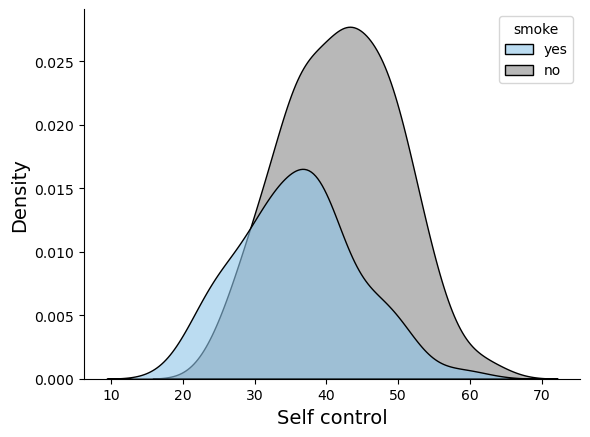

In [178]:
dens_plot = sns.kdeplot(data=df_METU, x="scontrol",
            hue="smoke_recode",
            hue_order=["yes","no"],
            fill=True,
            palette=["#8EC5E9","#8a8a8a"],
            alpha=0.6,
            edgecolor='black')
sns.move_legend(dens_plot,
                'best', bbox_to_anchor=(1, 1),
                title = "smoke")
plt.xlabel("Self control", 
               fontsize=14)
plt.ylabel("Density", 
               fontsize=14)
sns.despine()

$$\begin{equation}
\begin{array}{lcrl} 
\text{data:} & \hspace{.05in} & Y_i|\beta_0,\beta_1,\sigma & \stackrel{ind}{\sim} N(\mu_i, \; \sigma^2) \;\; \text{ with } \;\; \mu_i = \beta_0 + \beta_1 X_{i2}\\
\text{priors:} & & \beta_{0}  &  \sim N\left(45, 2^2\right)  \\
                     & & \beta_1  & \sim N\left(-10, 4^2 \right) \\
                     & & \sigma & \sim \text{Exp}(0.6)  .\\
\end{array}
\end{equation}
$$

In [179]:
with pm.Model() as category_model:

    beta_0 = pm.Normal("beta_0", mu=45, sigma=2)          #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=-10, sigma=4)         #定义beta_1
    sigma = pm.Exponential("sigma", 0.6)                  #定义sigma

    smoke = pm.MutableData("smoke",df_METU.smoke)
    mu = beta_0 + beta_1*smoke                           #定义mu，讲自变量与先验结合

    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma, observed=df_METU.scontrol)   #定义似然：预测值y符合N(mu, sigma)分布
                                                                                #通过 observed 传入实际数据y 自我控制水平

In [180]:
#===========================
#     注意！！！以下代码可能需要运行1-2分钟左右
#===========================
with category_model:
    cat_regression = pm.sample(draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
                      tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                      chains=4,                     # 链数
                      discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                      random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 67 seconds.


In [181]:
with category_model:
    cat_ppc = pm.sample_posterior_predictive(cat_regression,
                                             random_seed=84735) 

Sampling: [y_est]


In [182]:
cat_ppc

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

计算MAE：

In [191]:
# 计算每个X取值下对应的后验预测模型的均值
cat_pre_x = cat_ppc.posterior_predictive["y_est"].stack(sample=("chain", "draw"))
cat_pre_y_mean = cat_pre_x.mean(axis=1).values

# 提取对应X值下的观测值Y，提取对应X值下的后验预测模型的均值
cat_MAE = pd.DataFrame({
    "smoke": df_METU.smoke,
    "scontrol_ppc_mean": cat_pre_y_mean,
    "scontrol_original": df_METU.scontrol 
})
cat_MAE.head(10)

,smoke,scontrol_ppc_mean,scontrol_original
index,,,
0,0,42.353902,39
1,1,35.799939,40
2,0,42.395431,40
3,0,42.326252,57
4,0,42.346681,63
5,1,35.807295,31
6,1,35.809208,40
7,1,35.749744,26
8,0,42.361468,36


In [184]:
from statistics import median

# 计算预测误差
cat_MAE["pre_error"] = cat_MAE["scontrol_original"] - cat_MAE["scontrol_ppc_mean"]

# 最后，计算预测误差的中位数
MAE = median(cat_MAE.pre_error)
print(f"计算得到的MAE: {MAE:.2f}")

计算得到的MAE: 0.18


计算后验预测区间

In [185]:
cat_ppc

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [186]:
# 定义函数，计算对应X下的观测值超出后验预测模型hdi范围的数量
def count_outlier(i,hdi=0.94,ppc=cat_ppc):
  # 提取第i个X的值
  X = ppc.constant_data["smoke"][i].values
  # 提取第i个X值对应的后验预测值
  pre_ys = ppc.posterior_predictive["y_est"].stack(sample=("chain", "draw"))[i].values
  # 提取对应X值下的观测值Y
  true_ys = ppc.observed_data["y_est"][i].values
  
  # 计算对应后验预测的hdi的上下限
  lower,upper = az.hdi(pre_ys, hdi_prob=hdi)
  
  # 判断是否超过 hdi 边界
  outlier = (true_ys > upper) | (true_ys < lower)

  return outlier


In [188]:
# 建立一个list,存储是否超过后验预测范围的判断结果
hdi_verify = []

# 使用循环，判断所有X对应的Y是否超出后验预测范围，并计数
for i in range(len(df_METU)):  
  hdi_verify.append(count_outlier(i, hdi=0.94))
  total_number = sum(hdi_verify)


print(f"所有超过后验预测范围观测值的数量: {total_number}")

所有超过后验预测范围观测值的数量: 8


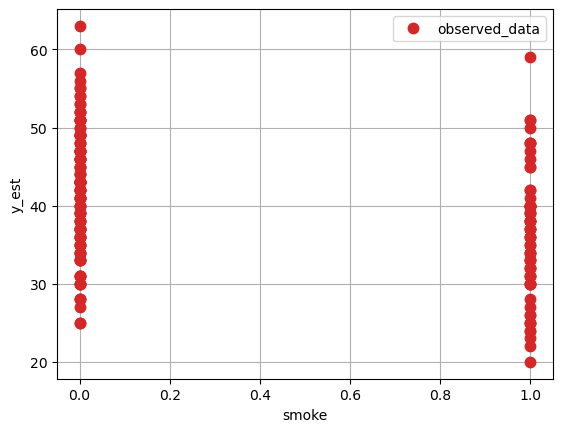

In [200]:
az.plot_lm(idata=cat_ppc,
           x=cat_ppc.constant_data["smoke"],
           y=cat_ppc.observed_data["y_est"])
plt.legend(loc="upper right")

Text(42.752936728395056, 0.5, 'Self control')

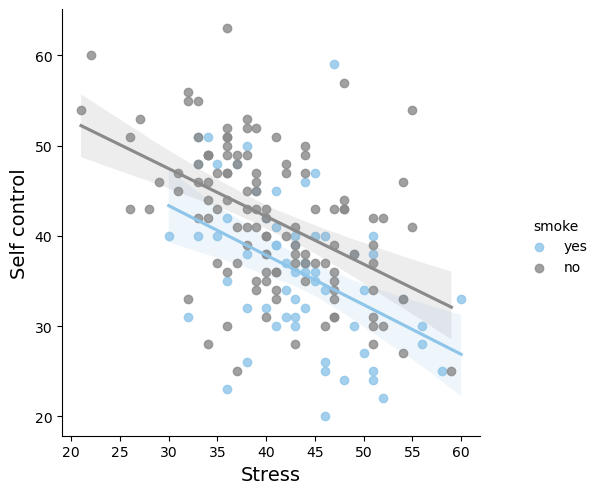

In [ ]:
lmplot = sns.lmplot(data=df_METU, x="stress",
                     y="scontrol",
                     hue="smoke_recode",
                     hue_order=["yes","no"],
                     palette=["#8EC5E9","#8a8a8a"])

# Set legend title
lmplot.legend.set_title("smoke")

plt.xlabel("Stress", 
               fontsize=14)

plt.ylabel("Self control", 
               fontsize=14)

$$  
\begin{equation}  
\begin{array}{lcrl}  

\text{data:} & \hspace{.05in} & Y_i|\beta_0,\beta_1,\beta_2,\sigma & \stackrel{ind}{\sim} N(\mu_i, \; \sigma^2)  \;\; \text{ with } \;\; \mu_i = \beta_0 + \beta_1X_{i1} + \beta_2X_{i2} \\
\text{priors:} & & \beta_{0}  & \sim N\left(70, 4^2 \right)  \\  
                    & & \beta_1  & \sim N\left(0, 0.8^2 \right) \\  
                    & & \sigma   & \sim \text{Exp}(0.6)  .\\  
\end{array}  
\end{equation}  
$$  

In [ ]:
with pm.Model() as linear_model_2:

    beta_0 = pm.Normal("beta_0", mu=70, sigma=4)          #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=0.8)         #定义beta_1
    beta_2 = pm.Normal("beta_2", mu=0, sigma=5)
    sigma = pm.Exponential("sigma", 0.6)                  #定义sigma

    stress = pm.MutableData("stress",df_METU.stress)                     #x是自变量压力水平
    smoke = pm.MutableData("smoke",df_METU.smoke)
    mu = beta_0 + beta_1*stress + beta_2*smoke                             #定义mu，讲自变量与先验结合

    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma, observed=df_METU.scontrol)   #定义似然：预测值y符合N(mu, sigma)分布
                                                                                #通过 observed 传入实际数据y 自我控制水平

In [ ]:
#===========================
#     注意！！！以下代码可能需要运行1-2分钟左右
#===========================
with linear_model_2:
    ss_regression = pm.sample(draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
                      tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                      chains=4,                     # 链数
                      discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                      random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 121 seconds.


In [ ]:
ss_regression

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data